In [1]:
# Initialize: import libraries

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, train_test_split, cross_validate, GridSearchCV



from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


# 1. Import and clean data

In [3]:
raw_data = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df = raw_data.copy(deep = True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
# Check missing data

def missing_data(df):
        total = df.isnull().sum().sort_values(ascending=False)
        percent_1 = df.isnull().sum()/df.isnull().count()*100
        percent_2 = (round(percent_1,1)).sort_values(ascending=False)
        percent_3 = df.count()
        missing_table = pd.concat([total,percent_2,percent_3],axis=1,keys=['Null','%','Count'])
        return(missing_table)
display(pd.concat([missing_data(df),pd.concat([df.dtypes,df.nunique()],axis = 1,keys = ['Type','Unique'])],axis = 1))

,Null,%,Count,Type,Unique
age,0,0.0,1338,int64,47
sex,0,0.0,1338,object,2
bmi,0,0.0,1338,float64,548
children,0,0.0,1338,int64,6
smoker,0,0.0,1338,object,2
region,0,0.0,1338,object,4
charges,0,0.0,1338,float64,1337


In [5]:
# Check Duplicate rows

duplicateRows = df[df.duplicated()]
duplicateRows

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [6]:
df_temp = df[df['charges']==1639.5631]
df_temp

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


We found that row 195 and 581 are duplicates.

In [7]:
# drop duplicate row

df = df.drop_duplicates()
duplicateRows = df[df.duplicated()]
duplicateRows

,age,sex,bmi,children,smoker,region,charges


Duplication are gone.

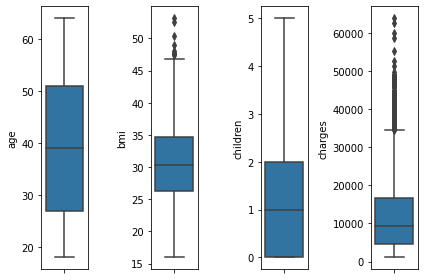

In [8]:
# Check for outlier for numeric data

fig,saxis = plt.subplots(1,4)
sns.boxplot(y = df.age,ax = saxis[0])
sns.boxplot(y = df.bmi,ax = saxis[1])
sns.boxplot(y = df.children,ax = saxis[2])
sns.boxplot(y = df.charges,ax = saxis[3])

plt.tight_layout()  # add padding between subplots to avoid overlapping

Outliers are found in 2 columns, including **bmi** and **charges**. Let see if those outliers make sense.

In [9]:
# Let see 

df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


* Maximaum **age** is 64 years old which is reasonable.
* **BMI** above 40 means obese class 3.
* Maximum amount of **charge** is 63,770. It is somewhat acceptable since the medical cost can be vary on case.

# 2. Exploratory Data Analysis (EDA) 

## Scatterplot

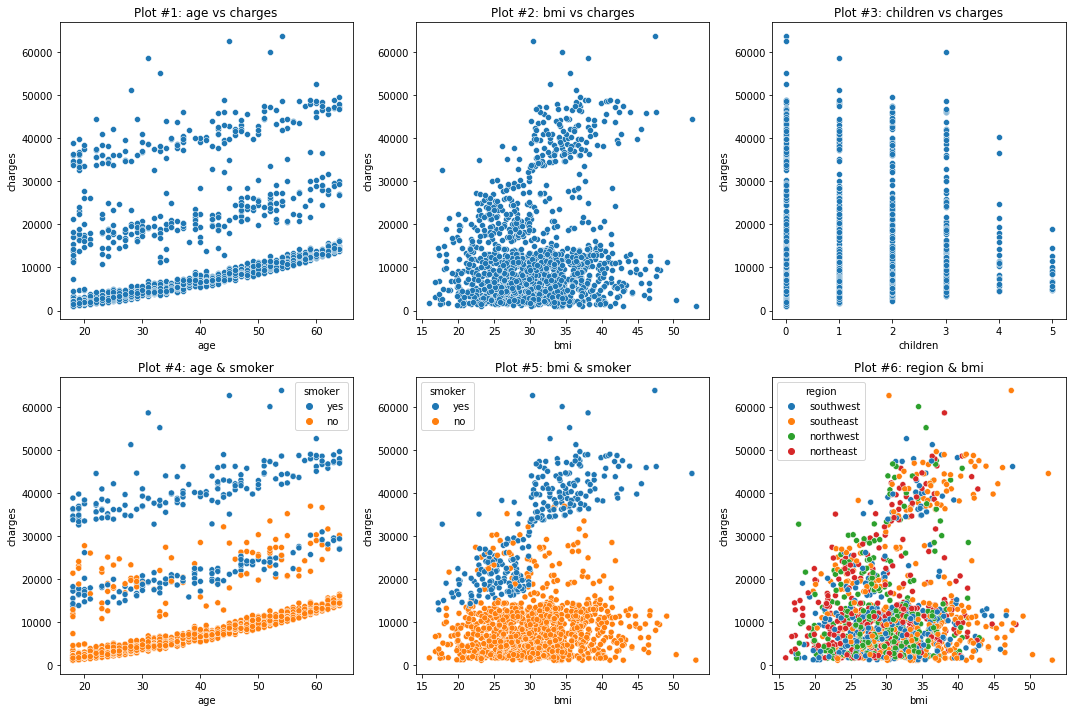

In [10]:
# EDA


fig,ax = plt.subplots(2, 3, figsize = (15,10))


sns.scatterplot(data=df, y='charges', x='age', ax=ax[0,0]).set(title='Plot #1: age vs charges')
sns.scatterplot(data=df, y='charges', x='bmi', ax=ax[0,1]).set(title='Plot #2: bmi vs charges')
sns.scatterplot(data=df, y='charges', x='children', ax=ax[0,2]).set(title='Plot #3: children vs charges')


sns.scatterplot(data=df, y='charges', x='age', hue='smoker', ax=ax[1,0]).set(title='Plot #4: age & smoker')
sns.scatterplot(data=df, y='charges', x='bmi', hue='smoker', ax=ax[1,1]).set(title='Plot #5: bmi & smoker')
sns.scatterplot(data=df, y='charges', x='bmi',hue='region', ax=ax[1,2]).set(title='Plot #6: region & bmi')

plt.tight_layout()  # add padding between subplots to avoid overlapping
plt.show()

* Plot1 shows that relationship between **age** and **charges** is very small, but we can see that data is crustered into 3 groups.
* Plot4 explains that **smoker** is the significant feature that group data in plot1
* Plot2 and plot5 show very similar relationship as plot1 and plot4, **smoker** is more significant than **bmi**.
* Plot3 and plot6 show the vague connection from **charges** to **children** and **region**.

## Histogram

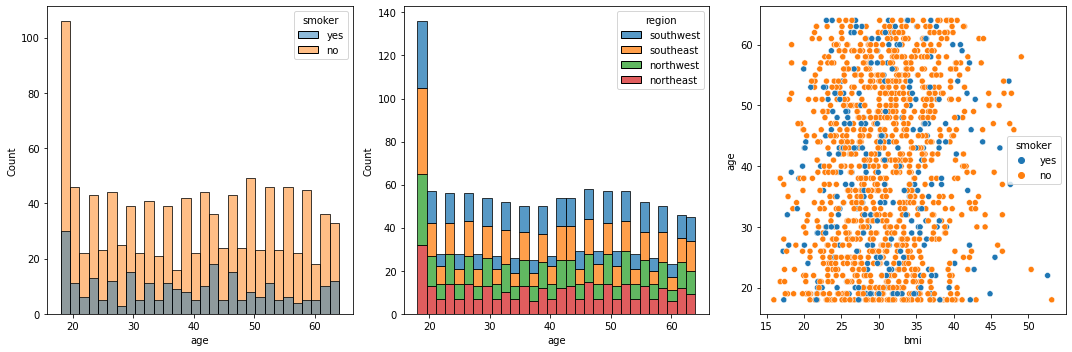

In [11]:
fig,ax = plt.subplots(1, 3, figsize = (15,5))

sns.histplot(data=df, x='age', hue='smoker', bins=30, ax=ax[0])  
sns.histplot(data=df, x='age', hue='region', bins=30,multiple="stack", ax=ax[1]) 
sns.scatterplot(data=df, y='age', x='bmi',hue='smoker', ax=ax[2])

plt.tight_layout()  # add padding between subplots to avoid overlapping
plt.show()

No significant relationship amoung non-target features.

## Correlation Matrix

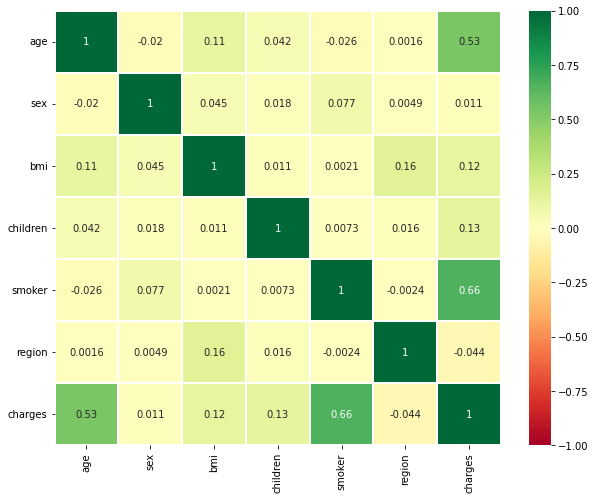

In [12]:
# Encode for correlation marix
df_encode = df.apply(LabelEncoder().fit_transform)


# Plot correlation marix
sns.heatmap(df_encode.corr(), vmin=-1, vmax=1, center=0,annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

We can see that top 3 most significant features are **smoker**, **age** and **children**, respectively.

# 3. Preprocess Data

In [13]:
# Dummy Dataframe
df_dummy = df.copy(deep=True)

# One hot encoding the categorical columns
cat_cols = ['sex', 'smoker', 'region', 'children']
df_dummy = pd.get_dummies(df_dummy, columns = cat_cols, drop_first = True)
df_dummy

,age,bmi,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.92400,0,1,0,0,1,0,0,0,0,0
1,18,33.770,1725.55230,1,0,0,1,0,1,0,0,0,0
2,28,33.000,4449.46200,1,0,0,1,0,0,0,1,0,0
3,33,22.705,21984.47061,1,0,1,0,0,0,0,0,0,0
4,32,28.880,3866.85520,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,10600.54830,1,0,1,0,0,0,0,1,0,0
1334,18,31.920,2205.98080,0,0,0,0,0,0,0,0,0,0
1335,18,36.850,1629.83350,0,0,0,1,0,0,0,0,0,0
1336,21,25.800,2007.94500,0,0,0,0,1,0,0,0,0,0


In [14]:
# Define Target and Features

target = ['charges']
y = df_dummy[target ]
X = df_dummy.drop(target , axis=1)

# Standradize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Model

In [15]:
# Define Models

seed = 10
models = [
    ('ridge',Ridge(random_state=0,tol=10)),
                    ('SVR',SVR(kernel='linear',C=1e2,degree=5)),
                    ('XGBR',XGBRegressor()),
                    ("Lasso",Lasso(random_state=seed,tol=1)),
                    ("Elastic",ElasticNet(random_state=seed)),
                    ("Random Forest",RandomForestRegressor(random_state=seed)),
                    ("Extra Trees",ExtraTreesRegressor(random_state=seed)),
                    ("BaggingR",BaggingRegressor(random_state=seed)),
                    ("Hub-Reg",HuberRegressor()),
                    ("BR",BayesianRidge()),
                    ("Decision Tree",DecisionTreeRegressor()),
                    ("KNN_reg",KNeighborsRegressor()),
                    ("GBoost-Reg",GradientBoostingRegressor())
                  ]

In [16]:
scoring = 'neg_root_mean_squared_error'
n_folds = 5

Model_columns = ['Model Name','RMSE Train Mean','RMSE Test Mean','std', 'Model Time']# ,'Model Parameters'
Model_compare = pd.DataFrame(columns = Model_columns)


row_index = 0
for name,model  in models:
        kfold = KFold(n_splits=n_folds)
        cv_results = cross_validate(model,X_scaled,y.values.ravel(),cv=kfold,scoring=scoring,n_jobs=-1,return_train_score=True)
        
        Model_name = model.__class__.__name__
        Model_compare.loc[row_index,'Model Name'] = Model_name  # names.append(name)
        Model_compare.loc[row_index,'Model Time'] = cv_results['fit_time'].mean()
        Model_compare.loc[row_index,'RMSE Train Mean'] = -cv_results['train_score'].mean()
        Model_compare.loc[row_index,'RMSE Test Mean'] = -cv_results['test_score'].mean()
        
        Model_compare.loc[row_index,'std'] = cv_results['test_score'].std()

        row_index+=1
        
Model_compare.sort_values(by = ['RMSE Test Mean'],ascending = True,inplace =True)
Model_compare


,Model Name,RMSE Train Mean,RMSE Test Mean,std,Model Time
12,GradientBoostingRegressor,3764.73001,4586.139584,377.248873,0.143787
5,RandomForestRegressor,1862.161456,5004.341397,304.595454,0.542436
7,BaggingRegressor,2157.663055,5119.235502,277.386168,0.068904
6,ExtraTreesRegressor,296.52359,5263.433819,432.883024,0.456173
2,XGBRegressor,870.968179,5392.338758,389.707445,0.696648
11,KNeighborsRegressor,4899.929387,6022.094567,86.25307,0.002669
0,Ridge,6025.290936,6081.721657,193.320435,0.005412
9,BayesianRidge,6025.414783,6081.768446,190.599999,0.008552
3,Lasso,6027.40593,6082.404219,187.657169,0.002753
10,DecisionTreeRegressor,296.52359,6856.358986,434.702877,0.006298


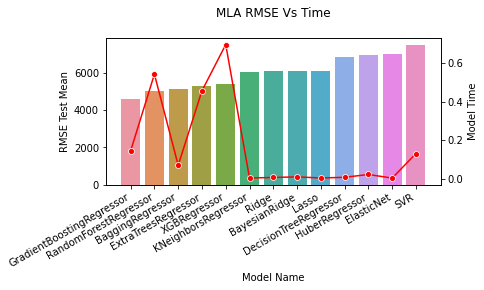

In [17]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(6,3))
sns.barplot(y = 'RMSE Test Mean', x = 'Model Name', data = Model_compare)

ax2 = ax1.twinx()


sns.lineplot(data = Model_compare,y = 'Model Time', x = 'Model Name', marker='o', sort = False, ax=ax2, color='red')

    
#prettify using pyplot
plt.title('MLA RMSE Vs Time\n')

plt.gcf().autofmt_xdate()
plt.show()

GradientBoostingRegressor and RandomForestRegressor work very as the initial run.

# 5. Optimize model

In [18]:
# Define GridSearch parameters

parameters = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators":[50,100,200]
    }

In [19]:
clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5, n_jobs=-1, scoring = 'neg_root_mean_squared_error')
clf.fit(X_scaled, y.values.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 8], 'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error')

In [20]:
print(clf.score(X_scaled, y.values.ravel()))
print(clf.best_params_)

-4135.379028079962
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}


The

Using hyperparameters from GridSearch reduce RMSE from 4586 to 4124.